# Analysis of property prices based on Zillow's dataset

In [1]:
import xlrd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

import sklearn as sk
import sklearn.tree as tree
from IPython.display import Image  
import pydotplus

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('County_time_series.csv')

In [3]:
lookup = pd.read_csv('CountyCrossWalk_Zillow.csv')

In [4]:
state_cd = pd.read_csv('us_states.csv')

In [5]:
df['Year'] = df.Date.str.split('-').str[0]

In [6]:
df['Year'] = pd.to_numeric(df['Year'])

In [7]:
dfmerge = df.merge(lookup, left_on = 'RegionName', right_on='FIPS', how = 'left')

In [8]:
dfdiag1 = dfmerge.merge(state_cd,left_on='StateName',right_on='State',how='left')

In [9]:
dfmerge.drop(['RegionName','StateFIPS', 'CountyFIPS', 'MetroName_Zillow','CountyRegionID_Zillow', 'MetroRegionID_Zillow', 
              'FIPS','CBSACode'], axis=1, inplace=True)

## <u> Preliminary analysis</u>

### <i><font color ='blue'>2017 - Top 10 states with the average house price</font></i>

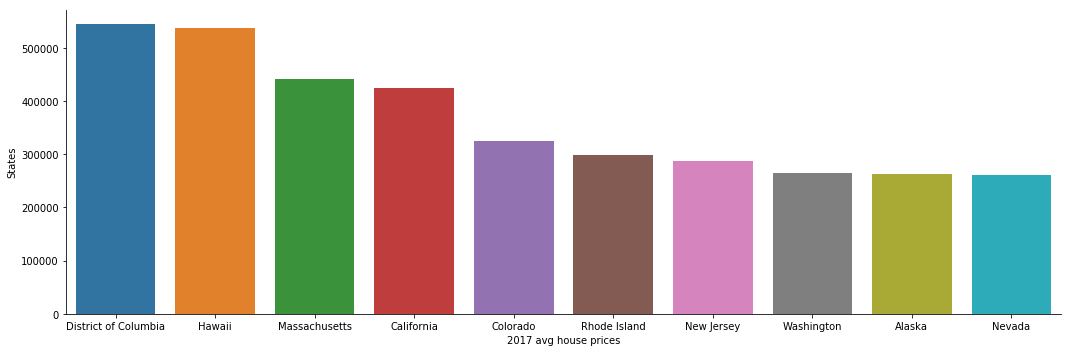

In [10]:
state_2017 = dfmerge[dfmerge.Year==2017].groupby('StateName',as_index=False)['ZHVI_AllHomes'].mean().sort_values(
    by='ZHVI_AllHomes',ascending=False).head(10)
sns.catplot(y='ZHVI_AllHomes',x='StateName',data=state_2017,aspect=3,kind='bar').set_axis_labels(
    "2017 avg house prices", "States");

### <i><font color ='blue'>2017 - Top 10 counties with the average house price</font></i>

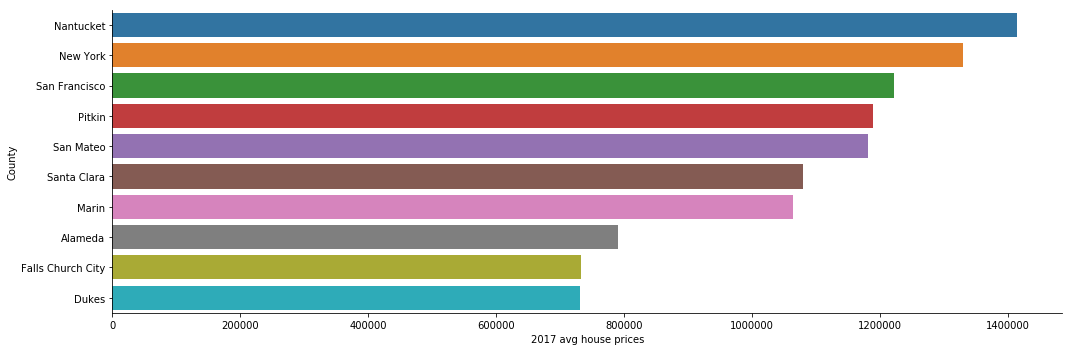

In [11]:
county_2017 = dfmerge[dfmerge.Year==2017].groupby('CountyName',as_index=False)['ZHVI_AllHomes'].mean().sort_values(
    by='ZHVI_AllHomes',ascending=False).head(10)
sns.catplot(x='ZHVI_AllHomes',y='CountyName',data=county_2017,aspect=3,kind='bar').set_axis_labels(
    "2017 avg house prices", "County");

### <font color='blue'><i>Buy or rent</i></font>
### <font color='blue'><i>As a general rule, a <font color='red'>lower</font> price-to-rent ratio indicates that a place is more <font color='red'>favorable to homebuyers</font>, while a <font color='red'>higher</font> ratio indicates a <font color='red'>better environment for renters</font>.</i></font>

In [12]:
df_state_avgZHVI = dfdiag1.groupby('Code',as_index=False)['PriceToRentRatio_AllHomes'].mean().dropna()

In [13]:
import plotly
from plotly import tools
import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
%matplotlib inline

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df_state_avgZHVI['Code'], 
        z = df_state_avgZHVI['PriceToRentRatio_AllHomes'].astype(float), 
        locationmode = 'USA-states', 
        text = 'Price to rent ratio',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Price:Rent ratio")
        ) ]
layout = dict(
        title = 'Average Price:Rent ratio - state wise<br>[1996-2017]',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )   
fig = dict( data=data, layout=layout )
# let's plot
py.iplot(fig)

# Findings

## <u>(1) Do unemployment rates affect property prices?</u>

### Summary: There is a definite correlation between unemployment rates and home values at the county level, and as seen later, a rate threshold below which counties have home values tend to increase in value on average.

### <font color='blue'><i>From the plot, it is clear that in most of these states, property prices fell after 2007 during the financial crisis. California saw the sharpest decline. Rates in all states started increasing 2012 onwards.<font color='red'> Surprisingly, property rates in Washington DC increased in 2009!!</font></i></font>

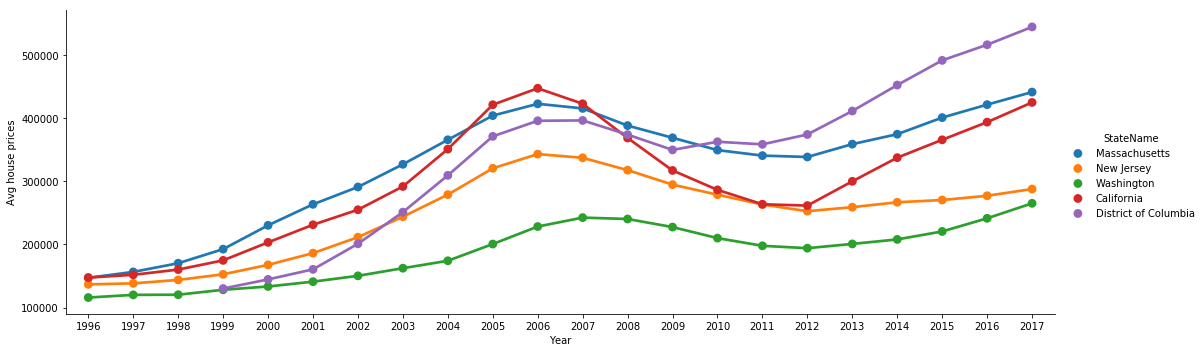

In [14]:
df_major = dfmerge.loc[(dfmerge.ZHVI_AllHomes.notnull()) & 
                          (dfmerge.StateName.isin(['California','District of Columbia', 
                                                     'Washington','Massachusetts','New Jersey'])),
                          ['StateName','ZHVI_AllHomes','Year']]
sns.catplot(x='Year',y='ZHVI_AllHomes',hue='StateName',data=df_major,height=5,aspect=3,ci=None, kind='point').set_axis_labels(
    "Year", "Avg house prices");

### <font color='blue'><i>Individual trends for each of the 5 major states. California was one of the worst hit during the subprime mortgage crisis period whereas the real estate market in DC performed relatively better than most states during the same period.  </font></i></font>

In [15]:
df_facet = df_major.groupby(['Year','StateName'],as_index=False)['ZHVI_AllHomes'].mean()

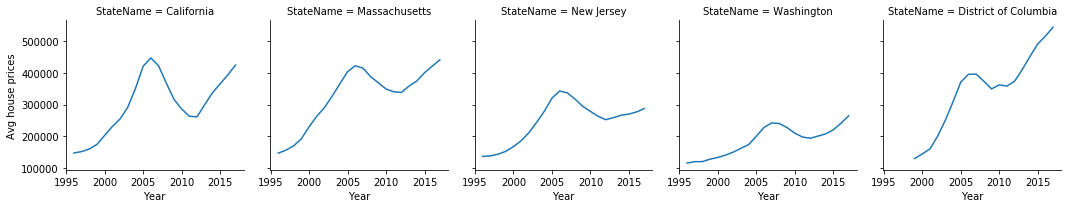

In [16]:
g = sns.FacetGrid(df_facet, col="StateName",col_wrap=5)
g.map(plt.plot, "Year", "ZHVI_AllHomes").set_axis_labels("Year", "Avg house prices");

### <font color='blue'><i>Perhaps the unemployment rate in DC did not increase as much as it did in states like California. Probably, unemployment rates play some role in property rates? </font></i></font>

### <font color='blue'><i>Read in the unemployment file, that contains data for CA, DC, WA, NJ and MA </font></i></font>

In [17]:
ue = pd.read_csv('CA_DC_un_rate.csv')

In [18]:
df_CADC = dfmerge[(dfmerge.StateName=='California')|(dfmerge.StateName=='District of Columbia')|
                  (dfmerge.StateName=='Massachusetts')|(dfmerge.StateName=='Washington')|(dfmerge.StateName=='New Jersey')]

In [19]:
df_CADC_grpby = df_CADC.groupby('CountyName',as_index=False)['PctOfHomesIncreasingInValues_AllHomes'].mean().rename(
    columns={'CountyName':'CountyName_y',
            'PctOfHomesIncreasingInValues_AllHomes':'Avg_pctofhomesinc'})

In [20]:
df_CADC_ue = df_CADC.merge(ue,left_on=['Date','StateName'],right_on=['DATE','State'],how='left')

### <font color='blue'><i>To check the effect of unemployment rates on property prices, we plot unemployment rates and real estate market growth. Regions considered are Massachusetts, New Jersey, Washington, California, and DC. It seems unemployment rate has some effect.</font></i></font>

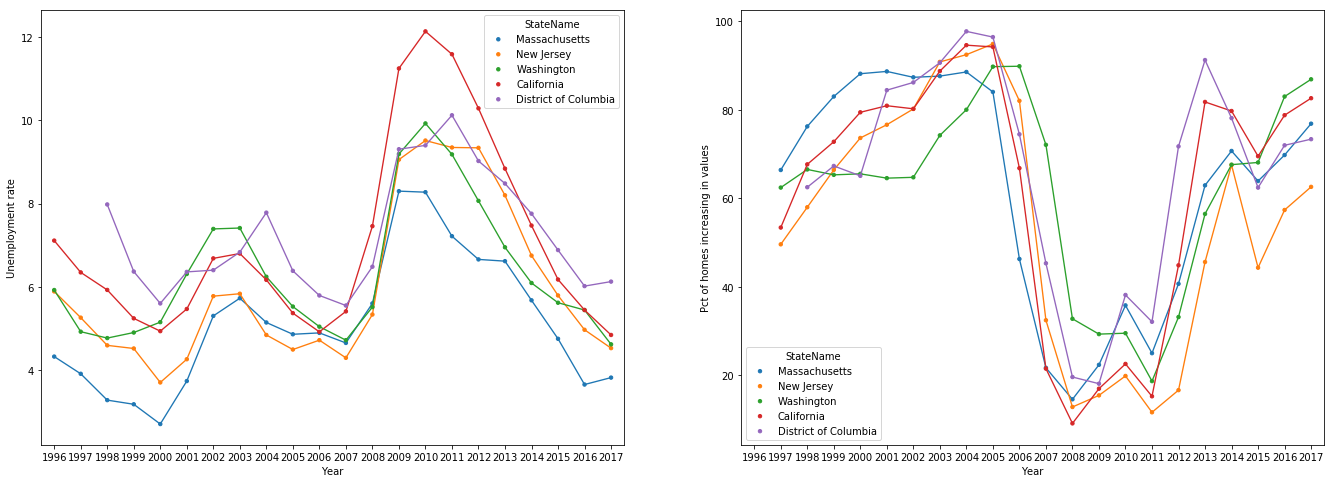

In [21]:
fig, (ax1,ax2) =plt.subplots(1,2,figsize=(23,8))
sns.catplot(x='Year',y='UR',hue='StateName',data=df_CADC_ue,ci=None,scale=0.5,ax=ax1, kind='point').set_axis_labels("Year", 
                                                                                                        "Unemployment rate")
sns.catplot(x='Year',y='PctOfHomesIncreasingInValues_AllHomes',hue='StateName',data=df_CADC_ue,ci=None,scale=0.5,
               ax=ax2, kind='point').set_axis_labels("Year", "Avg house prices")
plt.xlabel('Unemployment Rate')
plt.close(2)
plt.close(3)
ax1.set_ylabel('Unemployment rate')
ax2.set_ylabel('Pct of homes increasing in values');

### <font color='blue'><i>We generate a classification tree to check how unemployment rate plays a part. We check for a given month, if each county performs better than it's overall average. Performance is based on the percentage of homes in a county that increase in value. Also considered are unemployment rates for each month.</font></i></font>

In [22]:
df_CADC_merge = df_CADC_ue.merge(df_CADC_grpby,left_on='CountyName',right_on='CountyName_y',how='left')

In [23]:
df_CADC_merge.drop('CountyName_y',axis=1,inplace=True)

In [24]:
dfsub_CADC_merge = df_CADC_merge[['StateName','ZHVI_AllHomes',
                           'InventorySeasonallyAdjusted_AllHomes',
                           'PctOfHomesIncreasingInValues_AllHomes',
                           'PctOfListingsWithPriceReductionsSeasAdj_AllHomes',
                            'DaysOnZillow_AllHomes',
                           'UR','Year','Avg_pctofhomesinc']]

In [25]:
dfsub_CADC_merge.dropna(inplace=True)

### <font color='blue'><i>Transform Years and State names to dummies to check for variation.</font></i></font>

In [26]:
dfsub_CADC_merge = pd.get_dummies(dfsub_CADC_merge,columns=['Year','StateName'])

In [27]:
dfsub_CADC_merge['>County_Avg'] = (dfsub_CADC_merge['PctOfHomesIncreasingInValues_AllHomes'] > 
                                  dfsub_CADC_merge['Avg_pctofhomesinc'])*1.0

In [28]:
X1 = dfsub_CADC_merge.drop(['PctOfHomesIncreasingInValues_AllHomes','Avg_pctofhomesinc','>County_Avg'],axis=1)

In [29]:
Y1 = dfsub_CADC_merge['>County_Avg']

In [30]:
dt1 = tree.DecisionTreeClassifier(max_depth=2)

In [31]:
dt1.fit(X1,Y1)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [32]:
np.array(Y1.unique(), dtype=np.string_)

array([b'0.0', b'1.0'], dtype='|S32')

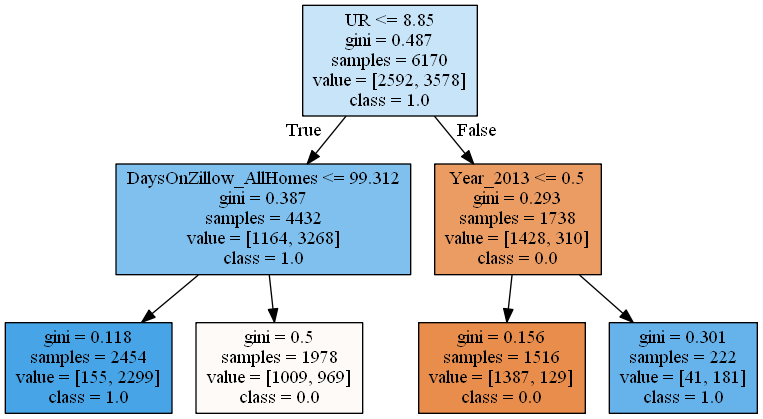

In [33]:
dt1_feature_names = list(X1.columns)
dt1_target_names = np.array(['0.0', '1.0']) 
tree.export_graphviz(dt1, out_file='tree1.dot', 
    feature_names=dt1_feature_names, class_names=dt1_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree1.dot')
Image(graph.create_png())

### <font color='blue'><i>When unemployment rate is less than 8.85, based on the how dynamic the market is (how long do homes stay on zillow), counties perform better than the historic avg.</i></font>
### <font color='blue'><i>When unemployment rate is higher than 8.85, counties do not perform better than the historic avg. An exception would be the year 2013, where certain counties performed better than the historic avg (Mostly in CA and DC).</i></font>

In [34]:
dfsub_CADC_merge1 = dfsub_CADC_merge
dfsub_CADC_merge1['UR_bin'] = dfsub_CADC_merge1.UR<=8.85
dfsub_CADC_merge1['DaysOnZillow_AllHomes_bin'] = dfsub_CADC_merge1.DaysOnZillow_AllHomes<=99.313
dfsub_CADC_merge1['Year_2013_bin'] = dfsub_CADC_merge1.Year_2013<=0.5

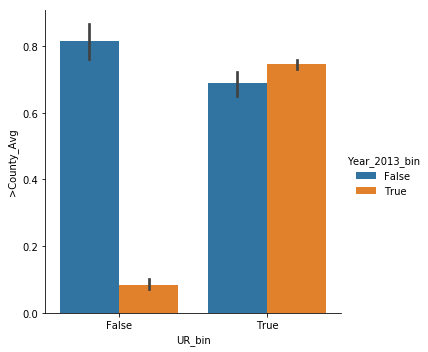

In [35]:
sns.catplot(y='>County_Avg',x='UR_bin',hue='Year_2013_bin',data=dfsub_CADC_merge1,kind='bar');

### Managerial Insight:

### <font color='blue'><i> Knowing the unemployment rate threshold which dictates whether houses will majorly gain in value is valuable information for real estate firms, lenders, insurance companies and even for homeowners seeking to buy (or sell). In case of a recession, this information is very useful for economists who might be devising bailout or loan-forgiveness strategies. For real estate firms, it can help reconfigure their investment strategies, or their marketing strategies, if already invested in areas of high unemployment.
</i></font>

--------------------------------------------------------------------------------------------------------------------------------

## <u> (2) County-level analysis of well-performing housing markets </u>

### Summary: A sign of a well-performing housing market (as measured by higher than average home values) is the number of days it spends on the market while being sold, and additionally, also the inventory present in that region.

### <font color='blue'><i>Calculate state averages for each time period in the dataset.</font></i></font>

In [36]:
dfstate_gby = dfmerge.groupby(['Date','StateName'],as_index=False)['ZHVI_AllHomes'].mean()
dfstate_gby.rename(columns={'Date':'Date_gby','StateName':'State_gby','ZHVI_AllHomes':'State_avg'},inplace=True)

In [37]:
df_ZHVI = dfmerge.merge(dfstate_gby,left_on=['Date','StateName'],right_on=['Date_gby','State_gby'],how='left')

In [38]:
df_ZHVI_sub = df_ZHVI[['StateName',
                       'ZHVI_AllHomes',
                       'InventorySeasonallyAdjusted_AllHomes',
                       #'Sale_Counts_Seas_Adj',
                       'PctOfHomesIncreasingInValues_AllHomes',
                       'PctOfListingsWithPriceReductionsSeasAdj_AllHomes',
                       'DaysOnZillow_AllHomes',
                       'State_avg',
                        #'MedianPriceCutDollar_AllHomes',
                        #'PriceToRentRatio_AllHomes',
                        #'UE_rate',
                        'Year']]

### <font color='blue'><i>For each time period, compare average property prices in a county to the state average and accordingly assign a 1 or a 0.</font></i></font>

In [39]:
df_ZHVI_sub['>State_avg'] = (df_ZHVI_sub['ZHVI_AllHomes'] > df_ZHVI_sub['State_avg']) * 1.0

In [40]:
df_ZHVI_sub.dropna(inplace=True)

### <font color='blue'><i>Create a dummy variable 'MajorMarkets' that contains 1 if the county is in California, District of Columbia, Hawaii, Massachusetts, New Jersey, New York, Washington, Alaska, Connecticut or Rhode Island.</font></i></font>

In [41]:
df_ZHVI_sub['MajorMarkets'] =  (df_ZHVI_sub.StateName.isin(['California','District of Columbia', 
                                                     'Hawaii','Massachusetts','NewJersey','NewYork',
                                                     'Washington','Alaska','Connecticut','Rhode Island']))*1

In [42]:
df_ZHVI_sub = pd.get_dummies(df_ZHVI_sub,columns=['Year'])

In [43]:
X2 = df_ZHVI_sub.drop(['ZHVI_AllHomes','State_avg','>State_avg','StateName'],axis=1)

In [44]:
Y2 = df_ZHVI_sub['>State_avg']

In [45]:
dt2 = tree.DecisionTreeClassifier(max_depth=2)

In [46]:
dt2.fit(X2,Y2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

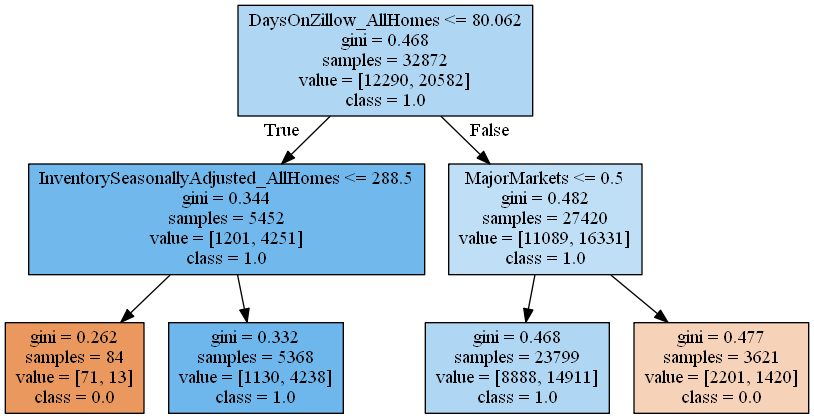

In [47]:
dt2_feature_names = list(X2.columns)
dt2_target_names = np.array(['0.0', '1.0']) 
tree.export_graphviz(dt2, out_file='tree2.dot', 
    feature_names=dt2_feature_names, class_names=dt2_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree2.dot')
Image(graph.create_png())

In [48]:
df_ZHVI_sub1 = df_ZHVI_sub
df_ZHVI_sub1['DaysonZillow_bin'] = df_ZHVI_sub1.DaysOnZillow_AllHomes<=80.063
df_ZHVI_sub1['Inventory_bin'] = df_ZHVI_sub1.InventorySeasonallyAdjusted_AllHomes<=288.5
df_ZHVI_sub1['MajorMarkets_bin'] = df_ZHVI_sub1.MajorMarkets<=0.5

C:\Users\vinit\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



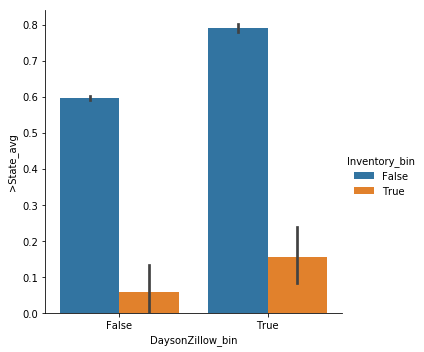

In [49]:
sns.factorplot(y='>State_avg',x='DaysonZillow_bin',hue='Inventory_bin',data=df_ZHVI_sub1,kind='bar')

### <font color='blue'><i> If a county's market is relatively active and big, it has a better chance of outperforming the state (wrt avg house prices). If a county's market is relatively inactive and if it does not fall in a major market state, it has slightly better chances of outperforming the state (the average house prices in those counties are higher than the state average). It also points to the fact that properties in these counties are priced too high wrt to the States they are in and thus they tend to stay unsold for long.</i></font>

### Managerial Insight:

### <font color='blue'><i> When selling a house (or sometimes, when purchasing one, in case of buyers making investment purchases), homeowners would like to know how much time it takes for a house to sell for many different reasons - they might be moving between houses or recouping past investment. Reinvesting decisions, or loans to be taken if purchasing a new house, might depend on the timeline of such a sale, since that determines the liquidity coming from the sale. On the other hand, people wanting another metric while buying a home can also use the number of days it remains on the market to judge whether it is a good investment decision or not.
</i></font>

--------------------------------------------------------------------------------------------------------------------------------

## <u>(3) Impact of Crime on Home Values</u>

### Summary: At the city level, home values depend more on violent crime than on property crime.

### <font color='blue'><i> Start of data loading and preparation </font></i>

In [50]:
city = pd.read_csv('City_time_series.csv')

In [51]:
city_names = pd.read_csv('cities_crosswalk.csv')

In [52]:
city = city_names.merge(city, left_on = 'Unique_City_ID', right_on='RegionName', how = 'right')

In [53]:
city['Year'] = city['Date'].apply(lambda x:x[:4])

In [54]:
city.drop(['RegionName','Unique_City_ID','Date','County'], axis = 1, inplace = True)

Take only 2014-2016 to merge because crime data is only from 2014-2016

In [55]:
city14_16 = city[(city.Year =='2016')|(city.Year =='2015')|(city.Year=='2014')]

In [56]:
city14_16.head(1)

,City,State,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,MedianListingPricePerSqft_AllHomes,...,ZHVI_CondoCoop,ZHVI_MiddleTier,ZHVI_SingleFamilyResidence,ZHVI_TopTier,ZRI_AllHomes,ZRI_AllHomesPlusMultifamily,ZriPerSqft_AllHomes,Zri_MultiFamilyResidenceRental,Zri_SingleFamilyResidenceRental,Year
213,Oak Grove,KY,119.0,119.0,NaN,NaN,87.412587,NaN,NaN,81.751055,...,NaN,92600.0,92600.0,115900.0,819.0,792.0,0.754,683.0,795.0,2014


Each row is currently a single month of data for a city, but we need it to be aggregated by year to match up with the crime data which only has yearly totals per city. So we will group by city, state, and year then take mean values.

In [57]:
city14_16 = city14_16.groupby(['City','State','Year']).mean().reset_index()

In [58]:
city14_16['City'] = city14_16['City'].apply(lambda x:x.replace('Township',''))
city14_16['City'] = city14_16['City'].apply(lambda x:x.rstrip(' '))

### <font color='blue'><i>Load Crime Data</font></i>

In [59]:
crime = pd.read_csv('crime14-16.csv')

In [60]:
crime['Year'] = crime['Year'].astype(str)

In [61]:
crime.head(1)

,State,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson,Year
0,AL,Abbeville,"2,643",8,0,1,NaN,0,7,85,22,52,11,NaN,2014


In [62]:
def county_drop(x):
    if 'County' in x:
        y = x.rsplit(None, 2)[0]
        return y.rstrip(', ')
    else:
        return x

In [63]:
crime['City'] = crime['City'].apply(lambda x:x.rstrip('0123456789'))
crime['City'] = crime['City'].apply(county_drop)
crime['City'] = crime['City'].apply(lambda x:x.replace('Township',''))
crime['City'] = crime['City'].apply(lambda x:x.rstrip(' '))

In [64]:
crime.drop(['Rape\n(revised\ndefinition)1','Rape\n(legacy\ndefinition)2'], axis = 1, inplace = True)

In [65]:
crime = crime[(crime.Population.notnull()) & (crime.Population != '0')]

In [66]:
crime.fillna(0, inplace = True)

In [67]:
crime.columns = ['State', 'City', 'Population', 'Violent_crime','Murder','Robbery','Aggravated_assault',
               'Property_crime','Burglary','Larceny_theft', 'Vehicle_theft', 'Arson', 'Year']

In [68]:
crime['Population'] = crime['Population'].apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Violent_crime'] = crime['Violent_crime'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Murder'] = crime['Murder'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Robbery'] = crime['Robbery'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Aggravated_assault'] = crime['Aggravated_assault'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Property_crime'] = crime['Property_crime'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Burglary'] = crime['Burglary'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Larceny_theft'] = crime['Larceny_theft'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Vehicle_theft'] = crime['Vehicle_theft'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)
crime['Arson'] = crime['Arson'].astype(str).apply(lambda x: x.replace(',','')).apply(pd.to_numeric)

Add columns for rate of crime per 10,000 people

In [69]:
crime['Violent_crime_rate'] = (crime['Violent_crime']/crime.Population)*10000
crime['Murder_rate'] = (crime['Murder']/crime.Population)*10000
crime['Robbery_rate'] = (crime['Robbery']/crime.Population)*10000
crime['Aggravated_assault_rate'] = (crime['Aggravated_assault']/crime.Population)*10000
crime['Property_crime_rate'] = (crime['Property_crime']/crime.Population)*10000
crime['Burglary_rate'] = (crime['Burglary']/crime.Population)*10000
crime['Larceny_theft_rate'] = (crime['Larceny_theft']/crime.Population)*10000
crime['Vehicle_theft_rate'] = (crime['Vehicle_theft']/crime.Population)*10000
crime['Arson_rate'] = (crime['Arson']/crime.Population)*10000

### <font color='blue'><i>We want to find the average crime rate for each state and add that as a new column to each row of city data. We will then be able to compare if a city has more or less crime than the average crime for the state in which that city resides.</font></i>

In [70]:
crime['avg_crime'] = crime[['Violent_crime_rate', 'Property_crime_rate']].mean(axis=1)

In [71]:
state_avg_crime = crime.groupby(['State','Year'])['avg_crime'].mean().reset_index().rename(columns={
        'avg_crime':'State_avg_crime_rate'})

In [72]:
state_avg_crime.head(1)

,State,Year,State_avg_crime_rate
0,AK,2014,165.400571


In [73]:
crime = crime.merge(state_avg_crime, right_on = ['State','Year'],left_on = ['State','Year'], how = 'left')

In [74]:
crime['above_avg_crime'] = (crime.avg_crime>crime.State_avg_crime_rate)*1.0

### <font color='blue'><i>Merge Crime with Real Estate Data</font></i>

In [75]:
city_with_crime = city14_16.merge(crime, left_on = ['City','State','Year'], right_on = ['City','State','Year'], how = 'right')

Similarly, we want to find the average home value for each state and add that as a new column to each row of city data. We will then be able to compare if a city has a higher or lower average home value than the average home value for the state in which that city resides.

In [76]:
avg_HV_by_state = city_with_crime.groupby(['State','Year'])['ZHVI_AllHomes'].median().reset_index()

In [77]:
avg_HV_by_state.columns = ['State','Year','State_avg_home_value']

In [78]:
avg_HV_by_state.head(1)

,State,Year,State_avg_home_value
0,AK,2014,206750.0


In [79]:
city_with_crime = city_with_crime.merge(
    avg_HV_by_state, right_on = ['State','Year'], left_on = ['State','Year'], how = 'left')

In [80]:
city_with_crime['above_avg_HV'] = (city_with_crime.ZHVI_AllHomes>city_with_crime.State_avg_home_value)*1.0

In [81]:
city_with_crime.head(1)

,City,State,Year,InventorySeasonallyAdjusted_AllHomes,InventoryRaw_AllHomes,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore,...,Property_crime_rate,Burglary_rate,Larceny_theft_rate,Vehicle_theft_rate,Arson_rate,avg_crime,State_avg_crime_rate,above_avg_crime,State_avg_home_value,above_avg_HV
0,Abbeville,AL,2014,97.416667,97.333333,NaN,NaN,NaN,NaN,NaN,...,321.604238,83.238744,196.746122,41.619372,0.0,175.936436,209.042392,0.0,118775.0,0.0


### <font color='blue'><i>Start of data analysis</font></i>

In [82]:
dftree = city_with_crime[['City','State','Year', 'Population','Violent_crime_rate', 'Property_crime_rate', 
            'PctOfHomesIncreasingInValues_AllHomes','InventorySeasonallyAdjusted_AllHomes',
            'ZHVI_AllHomes','above_avg_HV','above_avg_crime','Sale_Counts_Seas_Adj','avg_crime']]

In [83]:
dftree.dropna(inplace = True)

In [84]:
len(dftree)

6750

### <font color='blue'><i> Build a classification tree </font></i>

In [85]:
X = dftree.drop(['City','State','Year' ,'above_avg_HV','ZHVI_AllHomes',
               'Violent_crime_rate','InventorySeasonallyAdjusted_AllHomes'],axis = 1)
Y = dftree['above_avg_HV']

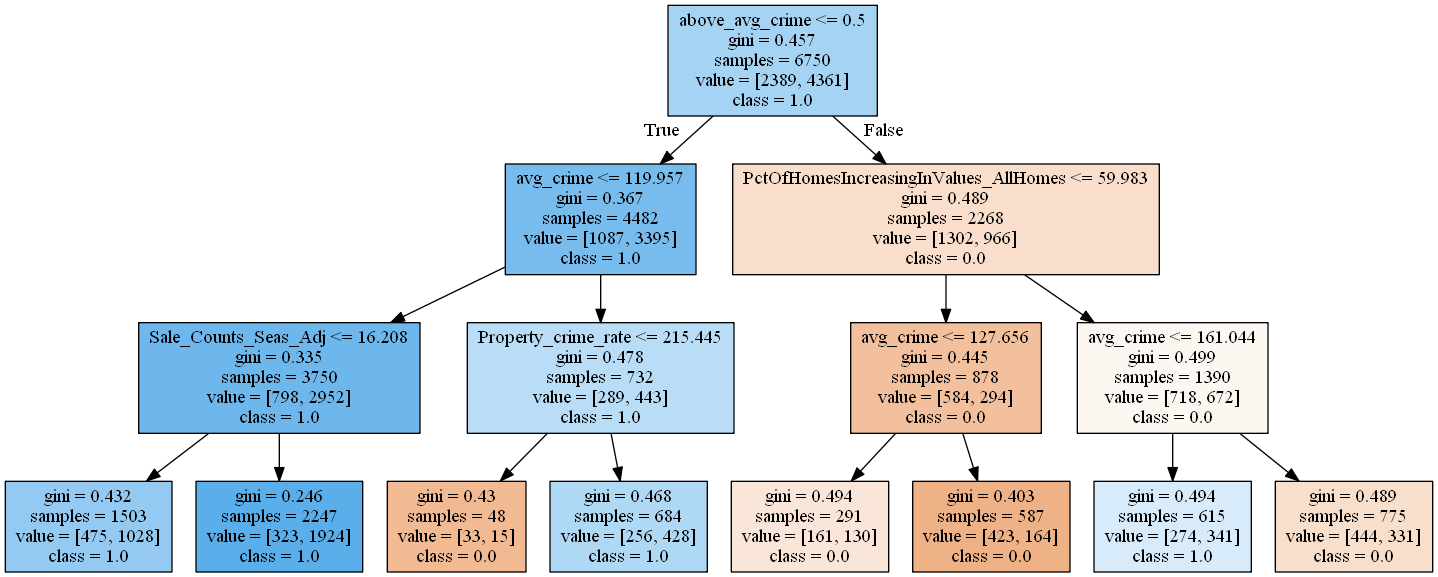

In [86]:
dt = tree.DecisionTreeClassifier(max_depth=3)
dt.fit(X,Y)
dt_feature_names = list(X.columns)
dt_target_names = np.array(['0.0', '1.0']) 
tree.export_graphviz(dt, out_file='tree.dot', 
    feature_names=dt_feature_names, class_names=dt_target_names,
    filled=True)  
graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [87]:
dftree['avg_crime_HIGH'] = (dftree['avg_crime']>=120)*1.0

In [88]:
dftree['Property_crime_rate_HIGH'] = (dftree['Property_crime_rate']>=215)*1.0

C:\Users\vinit\AppData\Local\Programs\Python\Python36\lib\site-packages\seaborn\categorical.py:3666: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



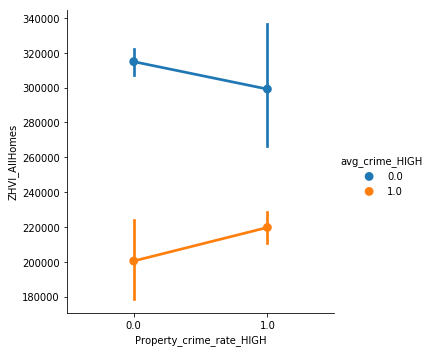

In [89]:
sns.factorplot(hue ='avg_crime_HIGH' , y = 'ZHVI_AllHomes', x = 'Property_crime_rate_HIGH', data = dftree)

###  <font color='blue'><i>In general, if a city has a crime rate below the state average, that city will likely have above the state average home values which is expected. </font></i>
### <font color='orange'><i>However, it is interesting to note when looking at a lower depth on the left, that some cities have high crime rate(above 120 per 10,000) but within that group, if property crime rate is above 215 per 10,000 then the city has high home values where less property crime has low home values.</font></i>


### <font><i>Violent vs Property crime analysis based on tree results</font></i>

In [90]:
dftree.drop(['PctOfHomesIncreasingInValues_AllHomes','InventorySeasonallyAdjusted_AllHomes'], axis = 1).describe()

,Population,Violent_crime_rate,Property_crime_rate,ZHVI_AllHomes,above_avg_HV,above_avg_crime,Sale_Counts_Seas_Adj,avg_crime,avg_crime_HIGH,Property_crime_rate_HIGH
count,6.750000e+03,6750.000000,6750.000000,6.750000e+03,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000,6750.000000
mean,4.513610e+04,22.740293,203.731701,2.795421e+05,0.646074,0.336000,62.997625,113.235997,0.365037,0.372741
std,2.249730e+05,26.691796,154.149739,2.407563e+05,0.478222,0.472374,173.953503,85.803645,0.481476,0.483570
min,1.660000e+02,0.000000,0.000000,3.988333e+04,0.000000,0.000000,0.416667,0.000000,0.000000,0.000000
25%,7.759000e+03,6.389365,99.064595,1.465312e+05,0.000000,0.000000,12.250000,54.102449,0.000000,0.000000
50%,1.636000e+04,13.748854,171.311146,2.192875e+05,1.000000,0.000000,25.166667,94.222141,0.000000,0.000000
75%,3.589300e+04,28.913149,266.125656,3.326792e+05,1.000000,1.000000,54.833333,147.756615,1.000000,1.000000
max,8.566917e+06,385.515112,2476.351351,4.207875e+06,1.000000,1.000000,3927.833333,1289.434151,1.000000,1.000000


### <font color='blue'><i>From the table above, we describe the following 2 groups:</font></i>

### <font color='blue'><i>Group 1: Cities with property crime below average(less than 200) and violent crime above average (greater than 22)</font></i>

### <font color='blue'><i>Group 2: Cities with property crime above average(greater than 200) and violent crime below average (less than 22)</font></i>

In [91]:
group1_home_value = dftree[(dftree.Property_crime_rate<200)&(dftree.Violent_crime_rate>22)].ZHVI_AllHomes.mean()
group1_home_value

230586.50688370585

### <font color='blue'><i>The average home value for cities in group 1 is $230,586 </font></i>

In [92]:
dftree[(dftree.Property_crime_rate<200)&(dftree.Violent_crime_rate>22)].above_avg_HV.mean()

0.5183673469387755

### <font color='blue'><i>Only 51.8% of these cities have home values above the state average.  </font></i>

In [93]:
group2_home_value = dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].ZHVI_AllHomes.mean()
group2_home_value

275369.6691711001

### <font color='blue'><i>The average home value for cities in group 2 is $275,370 </font></i>

In [94]:
dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].avg_crime.mean()

147.3535756707686

In [95]:
dftree[(dftree.Property_crime_rate>200)&(dftree.Violent_crime_rate<22)].above_avg_HV.mean()

0.6802270577105014

### <font color='blue'><i>Group 2 has a total average crime of 147+ per 10,000 population. This puts group 2 puts it in the 75th percentile for crime so it is surprising that 68% of these cities have home values above the state average.</font></i>

### <font color='blue'><i>What's the percentage difference between the two groups? </font></i>

In [96]:
(group2_home_value-group1_home_value)/group1_home_value

0.19421414935601672

### <font color='blue'><i>Home values the cities of group 2 are <font color='red'>over 19% higher </font></font></i><font color='blue'><i>than home values of cities in group 1. <font></i>

### Managerial insight:

### <i><font color='blue'> We expected cities with higher crime to have lower home values, but found differences based on type of crime. Cities with high crime rates, but where that crime is predominantly property crime as opposed to violent crime, are actually more likely to have above average home values.</font></i>
### <i><font color='blue'> So if you are looking for a good home investment that is also a safe place to live, it would be recommended to be more concerned about finding a place where violent crime rates are low or at least decreasing and less concerned with property crime rates.</font></i>